## Initial Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

## Import time series data: Airline passenger traffic

In [2]:
data = pd.read_csv('Source Data/airline-passenger-traffic.csv', header=None)
data.columns = ['Month', 'Passengers']
data['Month'] = pd.to_datetime(data['Month'], format='%Y-%m')
data = data.set_index('Month')
data.head(12)

,Passengers
Month,
1949-01-01,112.0
1949-02-01,118.0
1949-03-01,132.0
1949-04-01,129.0
1949-05-01,121.0
1949-06-01,135.0
1949-07-01,148.0
1949-08-01,148.0
1949-09-01,136.0


## Time series analysis

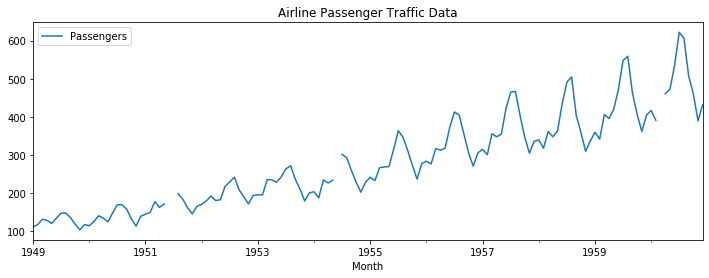

In [3]:
#Plot time series data
data.plot(figsize=(12, 4))
plt.legend(loc='best')
plt.title('Airline Passenger Traffic Data')
plt.show(block=False)

## Missing Value Treatment

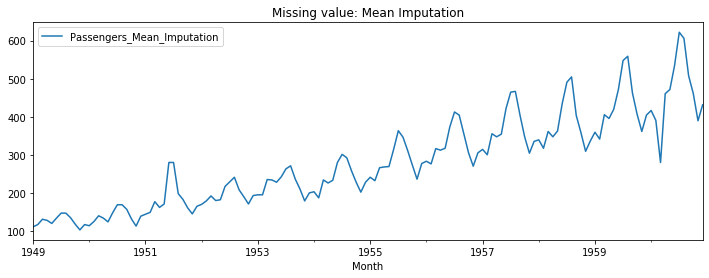

In [4]:
#Mean Imputation
data = data.assign(Passengers_Mean_Imputation = data.Passengers.fillna(data.Passengers.mean()))
data[['Passengers_Mean_Imputation']].plot(figsize=(12,4))
plt.legend(loc='best')
plt.title('Missing value: Mean Imputation')
plt.show(block=False)

### Linear Interpolation

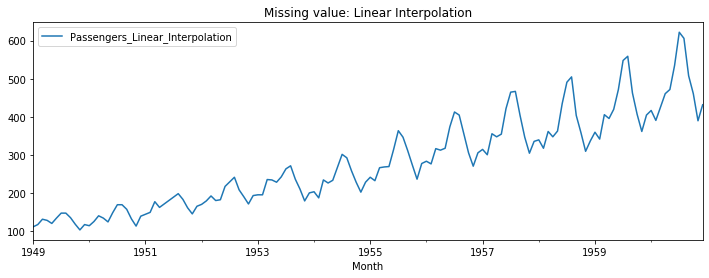

In [5]:
data = data.assign(Passengers_Linear_Interpolation = data.Passengers.interpolate(method='linear'))
data[['Passengers_Linear_Interpolation']].plot(figsize=(12,4))
plt.legend(loc='best')
plt.title('Missing value: Linear Interpolation')
plt.show(block=False)

In [6]:
data['Passengers'] = data['Passengers_Linear_Interpolation']

## Outlier Detection

### Box plot and interquartile range

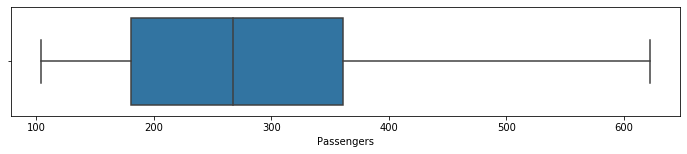

In [7]:
import seaborn as sns
fig = plt.subplots(figsize=(12,2))
ax = sns.boxplot(x = data['Passengers'], whis=1.5)

### Plot Histogram

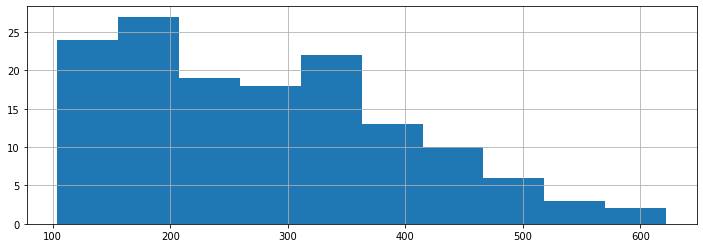

In [8]:
fig = data.Passengers.hist(figsize=(12,4))

## Time Series Decomposition

### Additive seasonal decomposition

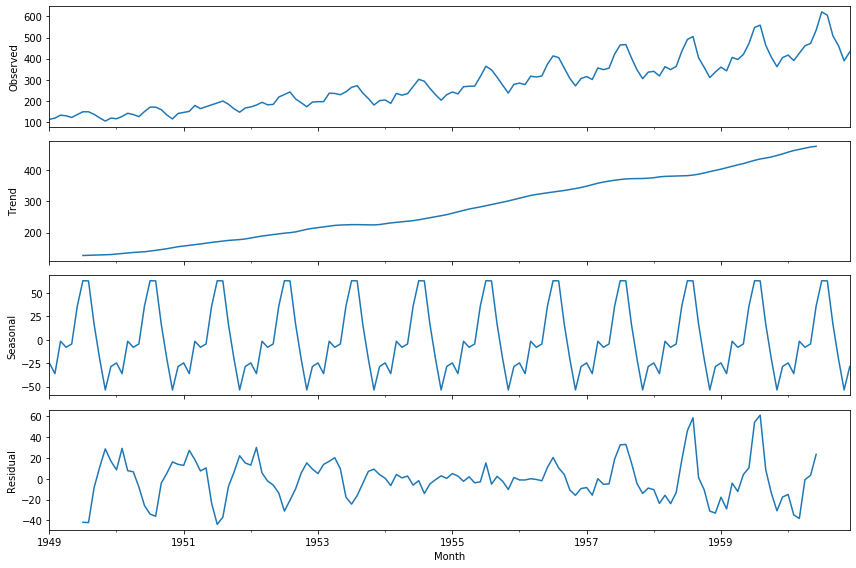

In [9]:
from pylab import rcParams
import statsmodels.api as sm
rcParams['figure.figsize'] = 12,8
decomposition = sm.tsa.seasonal_decompose(data.Passengers, model='additive')
fig = decomposition.plot()
plt.show()

### Multiplicative seasonal decomposition

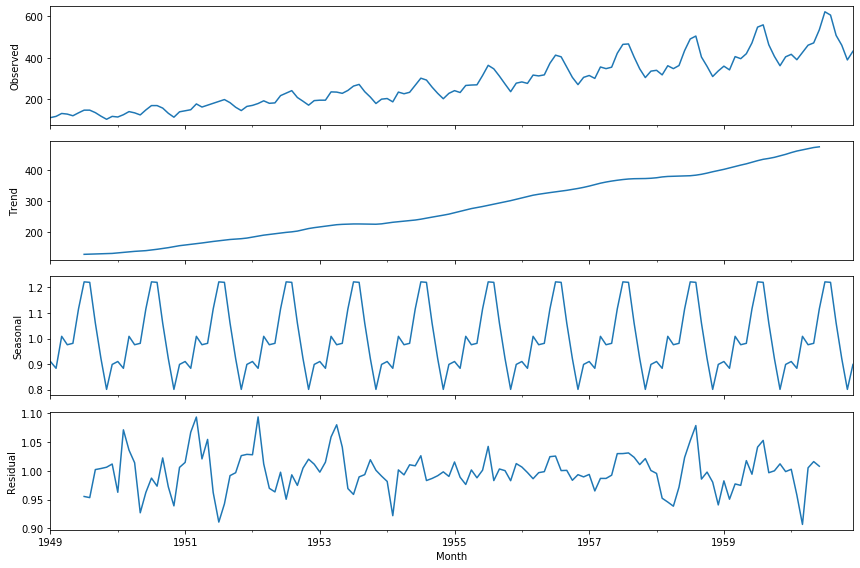

In [10]:
decomposition = sm.tsa.seasonal_decompose(data.Passengers, model='multiplicative')
fig = decomposition.plot()
plt.show()

## Build and evaulate time series forecast

### Splitting time series into Training and Test Sets

In [11]:
train_len = 120
train = data[0:train_len]
test = data[train_len:]

### Naive Method

In [12]:
y_hat_naive = test.copy()  #Initializing y_hat_naive with the test data as we need to forecast for the same date range.
y_hat_naive['naive_forecast'] = train['Passengers'][train_len-1]

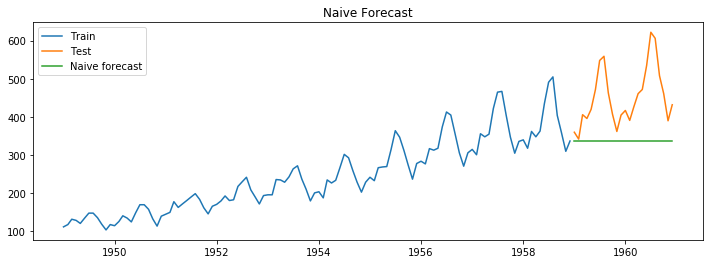

In [13]:
plt.figure(figsize=(12,4))
plt.plot(train['Passengers'], label='Train')
plt.plot(test['Passengers'], label='Test')
plt.plot(y_hat_naive['naive_forecast'], label='Naive forecast')
plt.legend(loc='best')
plt.title('Naive Forecast')
plt.show()

## Calculate RMSE and MAPE to evaulate forecast - naive method

In [14]:
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(test['Passengers'], y_hat_naive['naive_forecast'])).round(2)
mape = np.round(np.mean(np.abs(test['Passengers']-y_hat_naive['naive_forecast'])/test['Passengers'])*100,2)

results = pd.DataFrame({'Method': ['Naive method'], 'MAPE': [mape], 'RMSE': [rmse]})
results = results[['Method', 'MAPE', 'RMSE']]
results

#MAPE - 23.63% meaning that 76.37% is the accuracy of our naive model.

,Method,MAPE,RMSE
0,Naive method,23.63,137.51


### Simple Average Method

In [15]:
y_hat_avg = test.copy()
y_hat_avg['avg_forecast'] = train['Passengers'].mean()

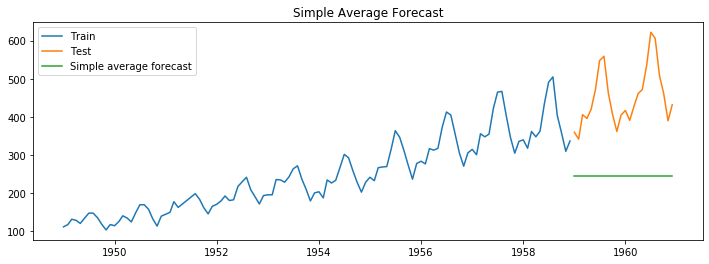

In [16]:
plt.figure(figsize=(12,4))
plt.plot(train['Passengers'], label='Train')
plt.plot(test['Passengers'], label='Test')
plt.plot(y_hat_avg['avg_forecast'], label='Simple average forecast')
plt.legend(loc='best')
plt.title('Simple Average Forecast')
plt.show()

## Calculate RMSE and MAPE to evaulate forecast - simple average method

In [17]:
rmse = np.sqrt(mean_squared_error(test['Passengers'], y_hat_avg['avg_forecast'])).round(2)
mape = np.round(np.mean(np.abs(test['Passengers']-y_hat_avg['avg_forecast'])/test['Passengers'])*100,2)

tempResults = pd.DataFrame({'Method': ['Simple average method'], 'MAPE': [mape], 'RMSE': [rmse]})
results = pd.concat([results,tempResults])
results

,Method,MAPE,RMSE
0,Naive method,23.63,137.51
0,Simple average method,44.28,219.69


## Simple moving average method

In [18]:
y_hat_sma = data.copy() #Initializing it with the entire data set as we want to see the past prediction
ma_window = 12
y_hat_sma['sma_forecast'] = data['Passengers'].rolling(ma_window).mean()
y_hat_sma['sma_forecast'][train_len:] = y_hat_sma['sma_forecast'][train_len-1] #Since we won't have the data for the test points
# hence updating it with last data point

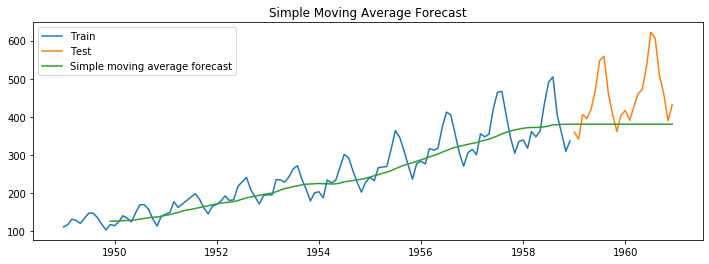

In [19]:
plt.figure(figsize=(12,4))
plt.plot(train['Passengers'], label='Train')
plt.plot(test['Passengers'], label='Test')
plt.plot(y_hat_sma['sma_forecast'], label='Simple moving average forecast')
plt.legend(loc='best')
plt.title('Simple Moving Average Forecast')
plt.show()

## Calculate RMSE and MAPE to evaulate forecast - simple moving average method

In [20]:
rmse = np.sqrt(mean_squared_error(test['Passengers'], y_hat_sma['sma_forecast'][train_len:])).round(2) # Using last 24 months data
mape = np.round(np.mean(np.abs(test['Passengers']-y_hat_sma['sma_forecast'][train_len:])/test['Passengers'])*100,2)

tempResults = pd.DataFrame({'Method': ['Simple moving average method'], 'MAPE': [mape], 'RMSE': [rmse]})
results = pd.concat([results, tempResults])
results

,Method,MAPE,RMSE
0,Naive method,23.63,137.51
0,Simple average method,44.28,219.69
0,Simple moving average method,15.54,103.33


## Simple Exponential Smoothing

In [21]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
model = SimpleExpSmoothing(train['Passengers'])
model_fit = model.fit(smoothing_level=0.2,optimized=False) # optimized = False - as wehave explictly mentioned the parameters.
model_fit.params
y_hat_ses = test.copy()
y_hat_ses['ses_forecast'] = model_fit.forecast(24)

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


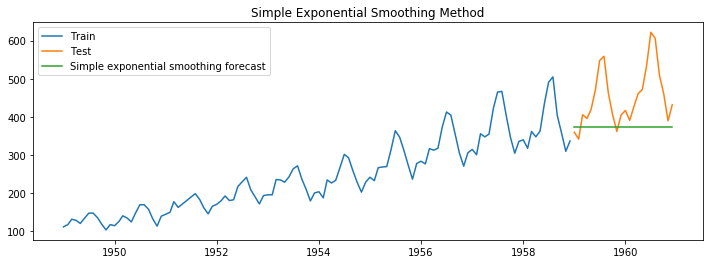

In [22]:
plt.figure(figsize=(12,4))
plt.plot(train['Passengers'], label='Train')
plt.plot(test['Passengers'], label='Test')
plt.plot(y_hat_ses['ses_forecast'], label='Simple exponential smoothing forecast')
plt.legend(loc='best')
plt.title('Simple Exponential Smoothing Method')
plt.show() # Level is been captured which is almost similar to the test data set

## Calculate RMSE and MAPE to evaulate forecast - Simple exponential smoothing method

In [23]:
rmse = np.sqrt(mean_squared_error(test['Passengers'], y_hat_ses['ses_forecast'])).round(2)
mape = np.round(np.mean(np.abs(test['Passengers']-y_hat_ses['ses_forecast'])/test['Passengers'])*100,2)

tempResults = pd.DataFrame({'Method': ['Simple exponential smoothing method'], 'MAPE': [mape], 'RMSE': [rmse]})
results = pd.concat([results, tempResults])
results

,Method,MAPE,RMSE
0,Naive method,23.63,137.51
0,Simple average method,44.28,219.69
0,Simple moving average method,15.54,103.33
0,Simple exponential smoothing method,16.49,107.65


## Holt's exponential smoothing method with Trend

In [24]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
model = ExponentialSmoothing(np.asarray(train['Passengers']), seasonal_periods=12, trend='additive', seasonal=None)
#As the trend is linear, hence, using additive
# The parameter needs an array and np.asarry() converts the dataFrame into an array
model_fit = model.fit(smoothing_level=0.2, smoothing_slope=0.01, optimized=False)
print(model_fit.params)
y_hat_holt = test.copy()
y_hat_holt['holt_forecast'] = model_fit.forecast(24)

{'smoothing_level': 0.2, 'smoothing_slope': 0.01, 'smoothing_seasonal': None, 'damping_slope': nan, 'initial_level': 112.0, 'initial_slope': 6.0, 'initial_seasons': array([], dtype=float64), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


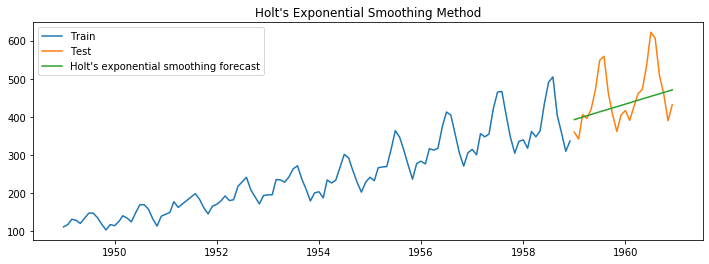

In [25]:
plt.figure(figsize=(12,4))
plt.plot(train['Passengers'], label='Train')
plt.plot(test['Passengers'], label='Test')
plt.plot(y_hat_holt['holt_forecast'], label='Holt\'s exponential smoothing forecast')
plt.legend(loc='best')
plt.title('Holt\'s Exponential Smoothing Method')
plt.show()

## Calculate RMSE and MAPE - Holt's exponential smoothing method

In [26]:
rmse = np.sqrt(mean_squared_error(test['Passengers'], y_hat_holt['holt_forecast'])).round(2)
mape = np.round(np.mean(np.abs(test['Passengers']-y_hat_holt['holt_forecast'])/test['Passengers'])*100,2)

tempResults = pd.DataFrame({'Method': ['Holt\'s exponential smoothing method'], 'MAPE': [mape], 'RMSE': [rmse]})
results = pd.concat([results,tempResults])
results = results[['Method', 'MAPE', 'RMSE']]
results

,Method,MAPE,RMSE
0,Naive method,23.63,137.51
0,Simple average method,44.28,219.69
0,Simple moving average method,15.54,103.33
0,Simple exponential smoothing method,16.49,107.65
0,Holt's exponential smoothing method,11.11,71.94


## Holt Winter's Additive Method with Trend and Seasonality

In [27]:
y_hat_hwa = test.copy()
model = ExponentialSmoothing(np.asarray(train['Passengers']), seasonal_periods=12, trend='add',seasonal='add')
model_fit = model.fit(optimized=True)
print(model_fit.params)
y_hat_hwa['hwa_forecast'] = model_fit.forecast(24)

{'smoothing_level': 0.2631578931410015, 'smoothing_slope': 0.05162966025765116, 'smoothing_seasonal': 0.7368421036673173, 'damping_slope': nan, 'initial_level': 211.55099866332293, 'initial_slope': 1.7391915752033313, 'initial_seasons': array([-100.18118437,  -94.2046477 ,  -80.29175565,  -83.41758365,
        -91.45908078,  -77.4509434 ,  -64.48324357,  -64.57340564,
        -76.66644176,  -93.73584142, -108.67610965,  -94.50947707]), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


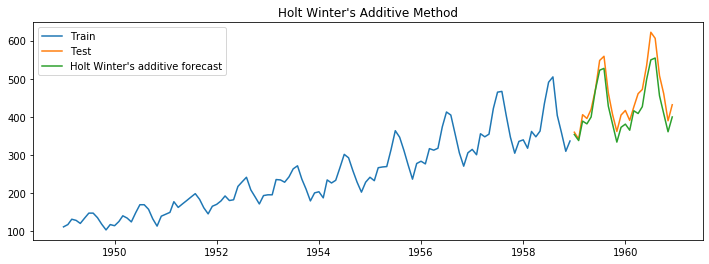

In [28]:
plt.figure(figsize=(12,4))
plt.plot(train['Passengers'], label='Train')
plt.plot(test['Passengers'], label='Test')
plt.plot(y_hat_hwa['hwa_forecast'], label='Holt Winter\'s additive forecast')
plt.legend(loc='best')
plt.title('Holt Winter\'s Additive Method')
plt.show()

## Calculate RMSE and MAPE to evaluate forecast - Holt Winter's additive method

In [29]:
rmse = np.sqrt(mean_squared_error(test['Passengers'], y_hat_hwa['hwa_forecast'])).round(2)
mape = np.round(np.mean(np.abs(test['Passengers']-y_hat_hwa['hwa_forecast'])/test['Passengers'])*100,2)

tempResults = pd.DataFrame({'Method': ['Holt Winter\'s additive method'], 'MAPE': [mape], 'RMSE': [rmse]})
results = pd.concat([results,tempResults])
results = results[['Method', 'MAPE', 'RMSE']]
results

,Method,MAPE,RMSE
0,Naive method,23.63,137.51
0,Simple average method,44.28,219.69
0,Simple moving average method,15.54,103.33
0,Simple exponential smoothing method,16.49,107.65
0,Holt's exponential smoothing method,11.11,71.94
0,Holt Winter's additive method,6.53,35.10


## Holt Winter's Multiplicative Method with Trend and Seasonality

In [30]:
y_hat_hwm = test.copy()
model = ExponentialSmoothing(np.asarray(train['Passengers']), seasonal_periods=12, trend='add',seasonal='mul')
model_fit = model.fit(optimized=True)
print(model_fit.params)
y_hat_hwm['hwm_forecast'] = model_fit.forecast(24)

{'smoothing_level': 0.38297792357726124, 'smoothing_slope': 0.035502695358352605, 'smoothing_seasonal': 0.6170220681283785, 'damping_slope': nan, 'initial_level': 212.3983506469908, 'initial_slope': 1.095376632423797, 'initial_seasons': array([0.51702061, 0.5454338 , 0.60215765, 0.56916567, 0.51982655,
       0.57235007, 0.62776238, 0.62555286, 0.57005795, 0.49511555,
       0.43967716, 0.51387414]), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


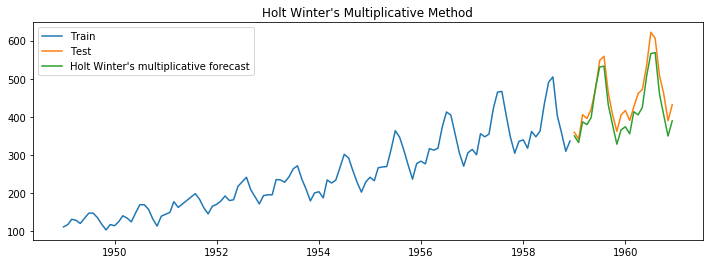

In [31]:
plt.figure(figsize=(12,4))
plt.plot(train['Passengers'], label='Train')
plt.plot(test['Passengers'], label='Test')
plt.plot(y_hat_hwm['hwm_forecast'], label='Holt Winter\'s multiplicative forecast')
plt.legend(loc='best')
plt.title('Holt Winter\'s Multiplicative Method')
plt.show()

## Calculate RMSE and MAPE to evaluate forecast - Holt Winter's multiplicative method

In [32]:
rmse = np.sqrt(mean_squared_error(test['Passengers'], y_hat_hwm['hwm_forecast'])).round(2)
mape = np.round(np.mean(np.abs(test['Passengers']-y_hat_hwm['hwm_forecast'])/test['Passengers'])*100,2)

tempResults = pd.DataFrame({'Method': ['Holt Winter\'s multiplicative method'], 'MAPE': [mape], 'RMSE': [rmse]})
results = pd.concat([results,tempResults])
results = results[['Method', 'MAPE', 'RMSE']]
results

,Method,MAPE,RMSE
0,Naive method,23.63,137.51
0,Simple average method,44.28,219.69
0,Simple moving average method,15.54,103.33
0,Simple exponential smoothing method,16.49,107.65
0,Holt's exponential smoothing method,11.11,71.94
0,Holt Winter's additive method,6.53,35.10
0,Holt Winter's multiplicative method,6.92,34.87


## Stationary vs non-stationary time series

### Time series plot

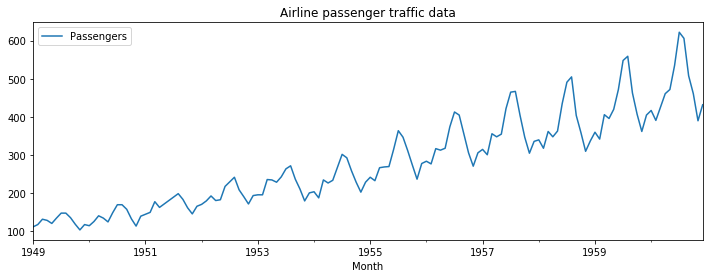

In [33]:
data['Passengers'].plot(figsize=(12,4))
plt.legend(loc='best')
plt.title('Airline passenger traffic data')
plt.show()

## Augumented Dickey-Fuller (ADF) Test

In [34]:
from statsmodels.tsa.stattools import adfuller
adf_test = adfuller(data['Passengers'])

print('ADF Statistics: %f' % adf_test[0])
print('Critical Value @ 0.05: %.2f' % adf_test[4]['5%'])
print('p-value: %f' %adf_test[1])

ADF Statistics: 0.894609
Critical Value @ 0.05: -2.88
p-value: 0.993020


## KPSS Test

In [35]:
from statsmodels.tsa.stattools import kpss
kpss_test = kpss(data['Passengers'])

print('KPSS Statistics: %f' % kpss_test[0])
print('Critical Value @ 0.05: %.2f' % kpss_test[3]['5%'])
print('p-value: %f' %kpss_test[1])

KPSS Statistics: 1.052050
Critical Value @ 0.05: 0.46
p-value: 0.010000


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1708: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)


## Box Cox Tranformation

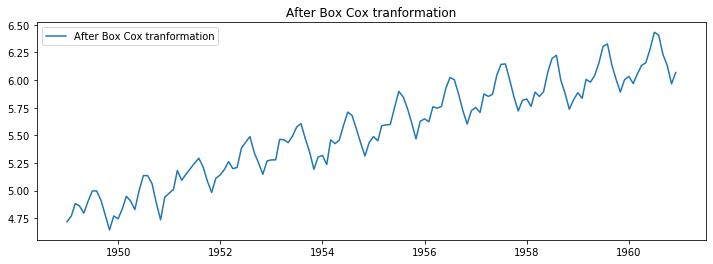

In [36]:
from scipy.stats import boxcox
data_boxcox = pd.Series(boxcox(data['Passengers'], lmbda=0), index = data.index)

plt.figure(figsize=(12,4))
plt.plot(data_boxcox, label='After Box Cox tranformation')
plt.legend(loc='best')
plt.title('After Box Cox tranformation')
plt.show()

## Differencing

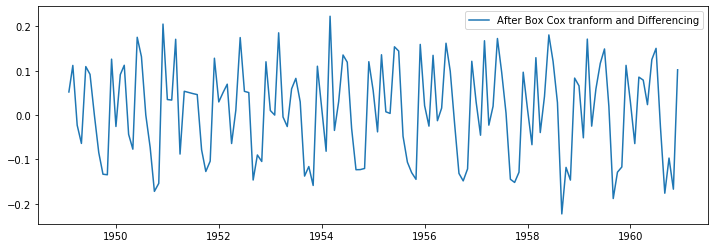

In [37]:
data_boxcox_diff = pd.Series(data_boxcox - data_boxcox.shift(), index = data.index)
data_boxcox_diff.dropna(inplace=True)

plt.figure(figsize=(12,4))
plt.plot(data_boxcox_diff, label='After Box Cox tranform and Differencing')
plt.legend(loc='best')
plt.show()

### ADF Test

In [38]:
adf_test = adfuller(data_boxcox_diff)

print('ADF Statistics: %f' % adf_test[0])
print('Critical Value @ 0.05: %f.2' % adf_test[4]['5%'])
print('p-value: %f' % adf_test[1])
# The series is stationary now.

ADF Statistics: -3.290114
Critical Value @ 0.05: -2.884042.2
p-value: 0.015326


### KPSS Test

In [39]:
kpss_test = kpss(data_boxcox_diff)

print('KPSS Statistics: %f' % kpss_test[0])
print('Critical Value @ 0.05: %f.2' % kpss_test[3]['5%'])
print('p-value: %f' % kpss_test[1])
# The series is stationary now.

KPSS Statistics: 0.101871
Critical Value @ 0.05: 0.463000.2
p-value: 0.100000


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1710: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


### Autocorrelation function (ACF) plot

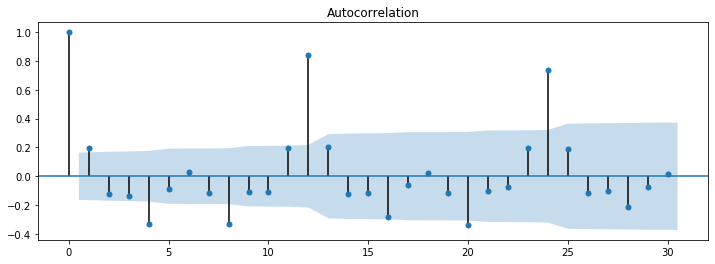

In [40]:
from statsmodels.graphics.tsaplots import plot_acf

plt.figure(figsize=(12,4))
plot_acf(data_boxcox_diff, ax=plt.gca(), lags=30)
plt.show()

#Anything which lies above the blue band has high correlation.

### Partial autocorrelation function (PACF) plot

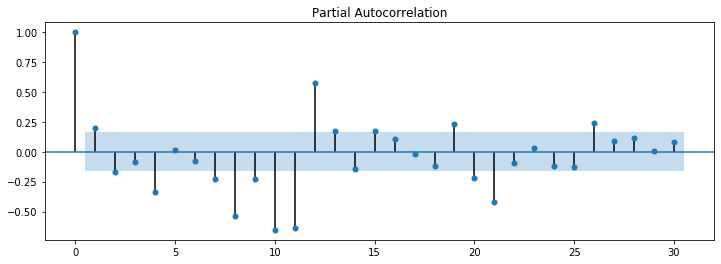

In [41]:
from statsmodels.graphics.tsaplots import plot_pacf

plt.figure(figsize=(12,4))
plot_pacf(data_boxcox_diff, ax=plt.gca(), lags=30)
plt.show()

## Split into training and test data

In [43]:
train_data_boxcox = data_boxcox[:train_len]
test_data_boxcox = data_boxcox[train_len:]
train_data_boxcox_diff = data_boxcox_diff[:train_len-1]
test_data_boxcox_diff = data_boxcox_diff[train_len-1:]

## Auto Regression method (AR)

In [44]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(train_data_boxcox_diff, order=(1,0,0))
model_fit = model.fit()
print(model_fit.params)

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


const      0.009477
ar.L1.y    0.183116
dtype: float64


### Recover original time series forecast 

In [ ]:
y_hat_ar = data_boxcox_diff.copy()
y_hat_ar['ar_forecast_boxcox_diff'] = model_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index_max())
y_hat_ar['ar_forecast_boxcox'] = y_hat_ar['ar_forecast_boxcox_diff'].cumsum()
y_hat_ar['ar_forecast_boxcox'] = y_hat_ar['ar_forecast_boxcox'].add(data_boxcox[0])
y_hat_ar['']